[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/tv_minimization_reconstruction_pdhg.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:tv_minimization_reconstruction_pdhg.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Total-variation (TV)-minimization reconstruction

### Image reconstruction
Here, we use the Primal Dual Hybrid Gradient (PDHG) algorithm to reconstruct an image from 2D radial k-space data.

Let $y$ denote the k-space data of the image $x_{\mathrm{true}}$ sampled with an acquisition model $A$
(Fourier transform, coil sensitivity maps, ...), i.e the forward problem is given as

$ y = Ax_{\mathrm{true}} + n, $

where $n$ describes complex Gaussian noise. When using TV-minimization as regularization method, an approximation of
$x_{\mathrm{true}}$ is obtained by minimizing the following functional $\mathcal{F}$ where $\nabla$ is the
discretized gradient operator.

$ \mathcal{F}(x) = \frac{1}{2}||Ax - y||_2^2 + \lambda \| \nabla x \|_1, \quad \quad \quad (1)$

The minimization of the functional $\mathcal{F}$ is a non-trivial task due to the presence of the operator
$\nabla$ in the non-differentiable $\ell_1$-norm. A suitable algorithm to solve the problem is the
PDHG-algorithm [[Chambolle \& Pock, JMIV 2011](https://doi.org/10.1007%2Fs10851-010-0251-1)].\
PDHG is a method for solving problems of the form

$ \min_x f(K(x)) + g(x)  \quad \quad \quad (2)$

where $f$ and $g$ denote proper, convex, lower-semicontinous functionals and $K$ denotes a linear operator.\
PDHG essentially consists of three steps, which read as

$z_{k+1} = \mathrm{prox}_{\sigma f^{\ast}}(z_k + \sigma K \bar{x}_k)$

$x_{k+1} = \mathrm{prox}_{\tau g}(x_k - \tau K^H z_{k+1})$

$\bar{x}_{k+1} = x_{k+1} + \theta(x_{k+1} - x_k)$,

where $\mathrm{prox}$ denotes the proximal operator and $f^{\ast}$ denotes the convex conjugate of the
functional $f$, $\theta\in [0,1]$ and step sizes $\sigma, \tau$ such that $\sigma \tau < 1/L^2$, where
$L=\|K\|_2$ is the operator norm of the operator $K$.

The first step is to recast problem (1) into the general form of (2) and then to apply the steps above
in an iterative fashion. In the following, we use this approach to reconstruct a 2D radial image using
`~mrpro.algorithms.optimizers.pdhg`.

### Load data
Our example data contains three scans acquired with a 2D golden angle radial trajectory and
varying number of spokes:

- ``radial2D_24spokes_golden_angle_with_traj.h5``
- ``radial2D_96spokes_golden_angle_with_traj.h5``
- ``radial2D_402spokes_golden_angle_with_traj.h5``

We will use the 402 spokes as a reference and try to reconstruct the image from the 24 spokes data.

In [2]:
# Download raw data from Zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


In [3]:
import mrpro

# We have embedded the trajectory information in the ISMRMRD files.
kdata_402spokes = mrpro.data.KData.from_file(
    data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
)
kdata_24spokes = mrpro.data.KData.from_file(
    data_folder / 'radial2D_24spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
)

### Comparison reconstructions
Before running the TV-minimization reconstruction, we first run a direct (adjoint) reconstruction
using `~mrpro.algorithms.reconstruction.DirectReconstruction` (see <project:direct_reconstruction.ipynb>)
of both the 24 spokes and 402 spokes data to have a reference for comparison.

In [4]:
direct_reconstruction_402 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_402spokes)
direct_reconstruction_24 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_24spokes)
img_direct_402 = direct_reconstruction_402(kdata_402spokes)
img_direct_24 = direct_reconstruction_24(kdata_24spokes)

We also run an iterative SENSE reconstruction (see <project:iterative_sense_reconstruction_radial2D.ipynb>) with early
stopping of the 24 spokes data. We use it as a comparison and as an initial guess for the TV-minimization
reconstruction.

In [5]:
sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata_24spokes,
    n_iterations=8,
    csm=direct_reconstruction_24.csm,
    dcf=direct_reconstruction_24.dcf,
)
img_sense_24 = sense_reconstruction(kdata_24spokes)

### Set up the operator $A$
Now, to set up the problem, we need to define the acquisition operator $A$, consisting of a
`~mrpro.operators.FourierOp` and a `~mrpro.operators.SensitivityOp`, which applies the coil sensitivity maps
(CSM) to the image. We reuse the CSMs estimated in the direct reconstruction.

In [6]:
fourier_operator = mrpro.operators.FourierOp.from_kdata(kdata_24spokes)

assert direct_reconstruction_24.csm is not None
csm_operator = direct_reconstruction_24.csm.as_operator()

# The acquisition operator is the composition of the Fourier operator and the CSM operator
acquisition_operator = fourier_operator @ csm_operator

### Recast the problem to be able to apply PDHG
To apply the PDHG algorithm, we need to recast the problem into the form of (2). We need to identify
the functionals $f$ and $g$ and the operator $K$. We chose an identification for which both
$\mathrm{prox}_{\sigma f^{\ast}}$ and $\mathrm{prox}_{\tau g}$ are easy to compute:

#### $f(z) = f(p,q) = f_1(p) + f_2(q) =  \frac{1}{2}\|p  - y\|_2^2 + \lambda \| q \|_1.$

In [7]:
regularization_lambda = 0.2
f_1 = 0.5 * mrpro.operators.functionals.L2NormSquared(target=kdata_24spokes.data, divide_by_n=True)
f_2 = regularization_lambda * mrpro.operators.functionals.L1NormViewAsReal(divide_by_n=True)
f = mrpro.operators.ProximableFunctionalSeparableSum(f_1, f_2)

#### $K(x) = [A, \nabla]^T$

  where $\nabla$ is the finite difference operator that computes the directional derivatives along the last two
  dimensions (y,x), implemented as `~mrpro.operators.FiniteDifferenceOp`, and
 `~mrpro.operators.LinearOperatorMatrix` can be used to stack the operators.

In [8]:
nabla = mrpro.operators.FiniteDifferenceOp(dim=(-2, -1), mode='forward')
K = mrpro.operators.LinearOperatorMatrix(((acquisition_operator,), (nabla,)))

#### $g(x) = 0,$

implemented as `~mrpro.operators.functionals.ZeroFunctional`

In [9]:
g = mrpro.operators.functionals.ZeroFunctional()

```{note}
An obvious identification would have been
- $f(x) = \lambda \| x\|_1,$
- $g(x) = \frac{1}{2}\|Ax  - y\|_2^2,$
- $K(x) = \nabla x.$

But to be able to compute $\mathrm{prox}_{\tau g}$, one would need to solve a linear system at each
iteration, making this identification impractical.
```

This identification allows us to compute the proximal operators of $f$ and $g$ easily.
### Run PDHG for a certain number of iterations
Now we can run the PDHG algorithm to solve the minimization problem. We use
the iterative SENSE image as an initial value to speed up the convergence.
```{note}
We can use the `callback` parameter of `~mrpro.algorithms.optimizers` to get some information
about the progress. In the collapsed cell, we implement a simple callback function that print the status
message
```

In [10]:
# This is a "callback" function that will be called after each iteration of the PDHG algorithm.
# We use it here to print progress information.

from mrpro.algorithms.optimizers.pdhg import PDHGStatus


def callback(optimizer_status: PDHGStatus) -> None:
    """Print the value of the objective functional every 16th iteration."""
    iteration = optimizer_status['iteration_number']
    solution = optimizer_status['solution']
    if iteration % 16 == 0:
        print(f'Iteration {iteration: >3}: Objective = {optimizer_status["objective"](*solution).item():.3e}')

In [11]:
(img_pdhg_24,) = mrpro.algorithms.optimizers.pdhg(
    f=f,
    g=g,
    operator=K,
    initial_values=(img_sense_24.data,),
    max_iterations=257,
    callback=callback,
)

Iteration   0: Objective = 2.123e-06


Iteration  16: Objective = 1.055e-06


Iteration  32: Objective = 8.169e-07


Iteration  48: Objective = 6.962e-07


Iteration  64: Objective = 6.233e-07


Iteration  80: Objective = 5.715e-07


Iteration  96: Objective = 5.312e-07


Iteration 112: Objective = 5.006e-07


Iteration 128: Objective = 4.756e-07


Iteration 144: Objective = 4.556e-07


Iteration 160: Objective = 4.387e-07


Iteration 176: Objective = 4.246e-07


Iteration 192: Objective = 4.115e-07


Iteration 208: Objective = 4.004e-07


Iteration 224: Objective = 3.907e-07


Iteration 240: Objective = 3.818e-07


Iteration 256: Objective = 3.737e-07


### Compare the results
We now compare the results of the direct reconstruction, the iterative SENSE reconstruction, and the TV-minimization

In [12]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


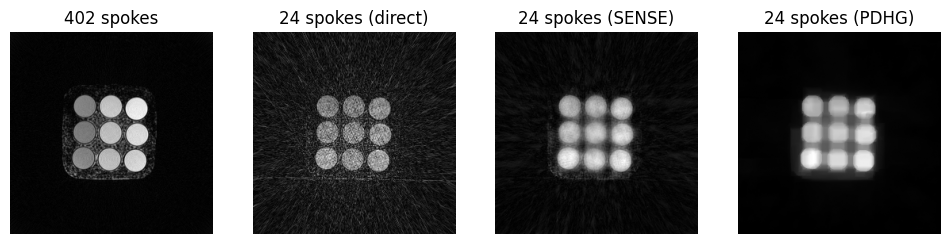

In [13]:
# see the collapsed cell above for the implementation of show_images
show_images(
    img_direct_402.rss().squeeze(),
    img_direct_24.rss().squeeze(),
    img_sense_24.rss().squeeze(),
    img_pdhg_24.abs().squeeze(),
    titles=['402 spokes', '24 spokes (direct)', '24 spokes (SENSE)', '24 spokes (PDHG)'],
)

Hurrah! We have successfully reconstructed an image from 24 spokes using TV-minimization.

### Next steps
Play around with the regularization weight and the number of iterations to see how they affect the final image.
You can also try to use the 96 spokes data to see how the reconstruction quality improves with more spokes.